In [4]:
from datetime import datetime
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# endereço dos dados

ENDERECO_DADOS = r'../../bronze/'
ENDERECO_VOTACAO = r'../../votacao/'

try:
    print('Obtendo os dados...')

    hora_inicial = datetime.now()

    # leitura dos dados
    df_bolsa_familia = pl.scan_parquet(ENDERECO_DADOS + 'bolsa_familia_str_cache.parquet')
    # print(df_bolsa_familia.head(5).collect())
    # print(df_bolsa_familia.types)

    df_votacao = pl.read_csv(ENDERECO_VOTACAO + 'votacao_secao_2022_BR.csv', separator=';', encoding='iso-8859-1')
    print(df_votacao.head(5))
    print(df_votacao.columns)
    print(df_votacao.shape)

    hora_final = datetime.now()
    print(f'Tempo de execução: {hora_final - hora_inicial}')

except Exception as e:
    print(f'Erro ao importar os dados: {e}')

Obtendo os dados...
shape: (5, 26)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ DT_GERACA ┆ HH_GERACA ┆ ANO_ELEIC ┆ CD_TIPO_E ┆ … ┆ NR_LOCAL_ ┆ SQ_CANDID ┆ NM_LOCAL_ ┆ DS_LOCAL │
│ O         ┆ O         ┆ AO        ┆ LEICAO    ┆   ┆ VOTACAO   ┆ ATO       ┆ VOTACAO   ┆ _VOTACAO │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ _ENDEREC │
│ str       ┆ str       ┆ i64       ┆ i64       ┆   ┆ i64       ┆ i64       ┆ str       ┆ O        │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 01/11/202 ┆ 16:05:25  ┆ 2.022     ┆ 2         ┆ … ┆ 1.015     ┆ 280.001.6 ┆ CENTRO    ┆ AV.      │
│ 2         ┆           ┆           ┆           ┆   ┆   

In [5]:
# Iniciar processamento
try:
    print('Iniciando processamento...')

    hora_inicial = datetime.now()

    # Fitra para Segundo Turno 'NR_TURNO' e
    # Número Votável NR_VOTAVEL 13 ou 22
    df_votacao = df_votacao.filter(
        (pl.col('NR_TURNO') == 2) & 
        (pl.col('NR_VOTAVEL').is_in([13, 22]))
    )

    # Ativar o Método Strig Cache do Polars para otimizar a performance.
    # Útil para Concatenação, Join "Merge" e etc.
    with pl.StringCache():        
        
        '''VOTAÇÃO'''        
        # Delimitando as colunas. Gera um Plano de Execução
        df_votacao = df_votacao.lazy().select(['SG_UF', 'NM_VOTAVEL', 'QT_VOTOS'])

        # Converte UF_SG e NM_VOTAVEL p/ categórico
        df_votacao = df_votacao.with_columns([
            pl.col('SG_UF').cast(pl.Categorical),
            pl.col('NM_VOTAVEL').cast(pl.Categorical)
        ])

        # Agruparar por UF e NM_VOTAVEL. Totalizar QT_VOTOS
        df_votacao = (
            df_votacao.group_by(['SG_UF', 'NM_VOTAVEL'])
            .agg(pl.col('QT_VOTOS').sum())
        )

        # Coletar os dados
        df_votacao = df_votacao.collect()
        # print(df_votacao)


        '''BOLSA FAMÍLIA'''
        # Delimitando as colunas. Gera um Plano de Execução
        df_bolsa_familia = df_bolsa_familia.lazy().select(['UF', 'VALOR PARCELA'])

        # Converte UF p/ categórico
        df_bolsa_familia = df_bolsa_familia.with_columns([
            pl.col('UF').cast(pl.Categorical)
        ])


        # Totalizar VALOR PARCELA por estado
        df_bolsa_familia = (
            df_bolsa_familia.group_by('UF')
            .agg(pl.col('VALOR PARCELA').sum())
        )

        # Coletar os dados
        df_bolsa_familia = df_bolsa_familia.collect()
        # print(df_bolsa_familia)

        # Juntar os dados Join
        df_votos_bolsa_familia = df_votacao.join(
            df_bolsa_familia, left_on='SG_UF', right_on='UF'
        )

    # Exibir todas as linhas
    # pl.Config.set_tbl_rows(-1)
    # print(df_votacao)

    # formatação numérica para o valor parcela
    pl.Config.set_float_precision(2)
    pl.Config.set_decimal_separator(',')
    pl.Config.set_thousands_separator('.')

    print(df_votos_bolsa_familia.head(5))

    hora_final = datetime.now()
    print(f'Tempo de processamento:  {hora_final - hora_inicial}')

except Exception as e:
    print(f'Erro ao processar os dados: {e}')

Iniciando processamento...
shape: (5, 4)
┌───────┬───────────────────────────┬───────────┬──────────────────┐
│ SG_UF ┆ NM_VOTAVEL                ┆ QT_VOTOS  ┆ VALOR PARCELA    │
│ ---   ┆ ---                       ┆ ---       ┆ ---              │
│ cat   ┆ cat                       ┆ i64       ┆ f64              │
╞═══════╪═══════════════════════════╪═══════════╪══════════════════╡
│ TO    ┆ LUIZ INÁCIO LULA DA SILVA ┆ 434.593   ┆ 527.092.444,00   │
│ AP    ┆ LUIZ INÁCIO LULA DA SILVA ┆ 189.918   ┆ 436.483.327,00   │
│ PB    ┆ JAIR MESSIAS BOLSONARO    ┆ 802.502   ┆ 2.210.367.798,00 │
│ SC    ┆ LUIZ INÁCIO LULA DA SILVA ┆ 1.351.918 ┆ 734.012.222,00   │
│ MA    ┆ LUIZ INÁCIO LULA DA SILVA ┆ 2.668.425 ┆ 4.252.676.548,00 │
└───────┴───────────────────────────┴───────────┴──────────────────┘
Tempo de processamento:  0:00:01.863896


In [6]:
# CORRELAÇÃO
try:
    print('Correlacionando os dados')
    hora_inicial = datetime.now()

    # dicionario candidato correlação
    dict_correlacoes = {}

    for candidato in df_votos_bolsa_familia['NM_VOTAVEL'].unique():
        # filtrar por candidatos
        df_candidato = df_votos_bolsa_familia.filter(pl.col('NM_VOTAVEL') == candidato)

        # Criar arrays com as variáveis QT_VOTOS e VALOR PARCELA
        array_votos = np.array(df_candidato['QT_VOTOS'])
        array_valor_parcela = np.array(df_candidato['VALOR PARCELA'])

        # CALCULAR O COEFICIENTE DE CORRELAÇÃO
        # O resultado é sempre uma Matriz (linha X coluna)
        # Todas as variáveis em linhas e todas em colunas
        correlacao = np.corrcoef(array_votos, array_valor_parcela)[0, 1]

        print(f'Correlação para {candidato}: {correlacao}')

        # Adicionar a correlação no dicionário
        dict_correlacoes[candidato] = correlacao
    
    hora_final = datetime.now()
    print(f'Correlação finalizada em {hora_final - hora_inicial}')

except Exception as e:
    print(f'Erro ao processar os dados: {e}')


Correlacionando os dados
Correlação para LUIZ INÁCIO LULA DA SILVA: 0.8968888927016996
Correlação para JAIR MESSIAS BOLSONARO: 0.6451146386646839
Correlação finalizada em 0:00:00.002584


Visualizando dados....
Visualização realizada com sucesso! Tempo de processamento:  0:00:00.282058


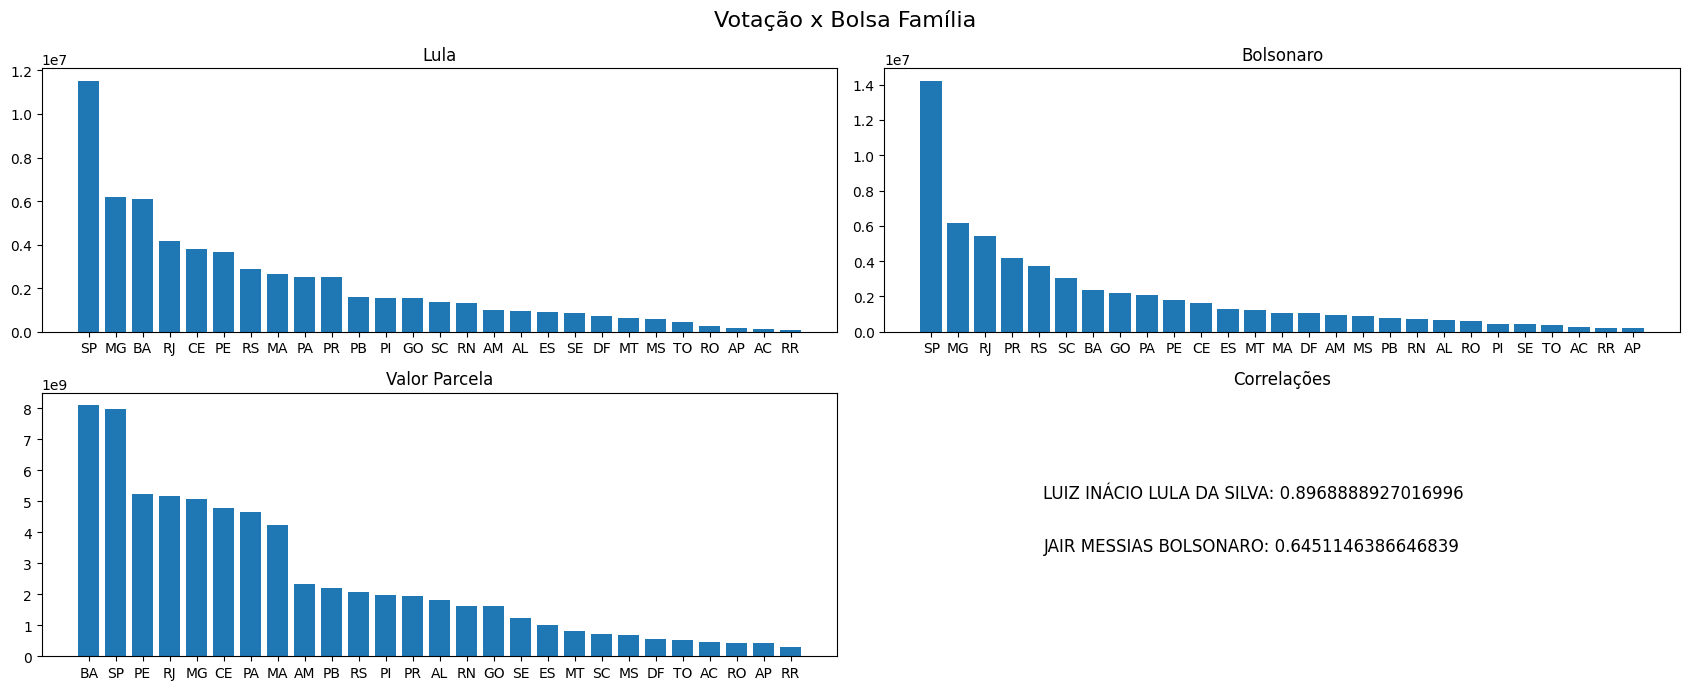

In [7]:
# VISUALIZAÇÃO
try:
    print('Visualizando dados....')
    hora_inicio = datetime.now()

    plt.subplots(2, 2, figsize=(17, 7))
    plt.suptitle('Votação x Bolsa Família', fontsize=16)

    #Posição 1: Ranking Lula
    plt.subplot(2, 2, 1)
    plt.title('Lula')

    df_lula = df_votos_bolsa_familia.filter(pl.col('NM_VOTAVEL') == 'LUIZ INÁCIO LULA DA SILVA')

    df_lula = df_lula.sort('QT_VOTOS', descending=True)

    plt.bar(df_lula['SG_UF'], df_lula['QT_VOTOS'])


    #Posição 2: Ranking Bolsonaro
    plt.subplot(2, 2, 2)
    plt.title('Bolsonaro')

    df_bolsonaro = df_votos_bolsa_familia.filter(pl.col('NM_VOTAVEL') == 'JAIR MESSIAS BOLSONARO')

    df_bolsonaro = df_bolsonaro.sort('QT_VOTOS', descending=True)

    plt.bar(df_bolsonaro['SG_UF'], df_bolsonaro['QT_VOTOS'])


    #Posição 3: Ranking do bolsa família por UF
    plt.subplot(2, 2, 3)
    plt.title('Valor Parcela')

    df_bolsa_familia = df_bolsa_familia.sort('VALOR PARCELA', descending=True)

    plt.bar(df_bolsa_familia['UF'], df_bolsa_familia['VALOR PARCELA'])


    #Posição 4: Correlação
    plt.subplot(2, 2, 4)
    plt.title('Correlações')

    # coordenadas do plt.text
    x = 0.2
    y = 0.6

    for candidato, correlacao in dict_correlacoes.items():
        plt.text(x, y, f'{candidato}: {correlacao}', fontsize=12)

        # reduzir 0.2 do eixo Y
        # y = y - 0.2
        y -= 0.2
    
    plt.axis('off')

    plt.tight_layout()

    hora_fim = datetime.now()
    print('Visualização realizada com sucesso! Tempo de processamento: ', hora_fim - hora_inicio)

    plt.show()
except ImportError as e:
    print('Erro ao visualizar dados: ', e)
    exit()

Gerando gráficos de dispersão...


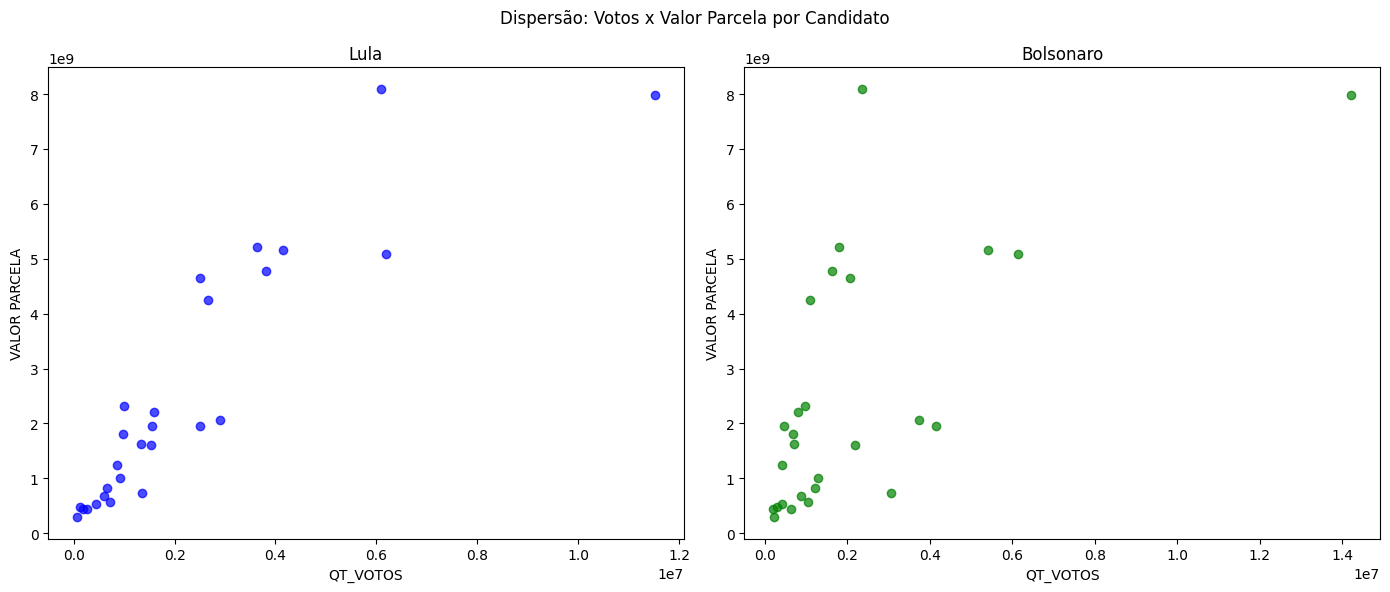

Gráficos de dispersão gerados com sucesso! Tempo de processamento:  0:00:00.234525


In [8]:
# SCATTER PLOT PARA CORRELAÇÃO
try:
    print('Gerando gráficos de dispersão...')
    hora_inicio = datetime.now()

    plt.figure(figsize=(14, 6))
    plt.suptitle('Dispersão: Votos x Valor Parcela por Candidato')

    # Subplot para Lula
    plt.subplot(1, 2, 1)
    df_lula = df_votos_bolsa_familia.filter(pl.col('NM_VOTAVEL') == 'LUIZ INÁCIO LULA DA SILVA')
    plt.scatter(df_lula['QT_VOTOS'], df_lula['VALOR PARCELA'], alpha=0.7, color='blue')
    plt.title('Lula')
    plt.xlabel('QT_VOTOS')
    plt.ylabel('VALOR PARCELA')

    # Subplot para Bolsonaro
    plt.subplot(1, 2, 2)
    df_bolsonaro = df_votos_bolsa_familia.filter(pl.col('NM_VOTAVEL') == 'JAIR MESSIAS BOLSONARO')
    plt.scatter(df_bolsonaro['QT_VOTOS'], df_bolsonaro['VALOR PARCELA'], alpha=0.7, color='green')
    plt.title('Bolsonaro')
    plt.xlabel('QT_VOTOS')
    plt.ylabel('VALOR PARCELA')

    plt.tight_layout()
    plt.show()

    hora_fim = datetime.now()
    print('Gráficos de dispersão gerados com sucesso! Tempo de processamento: ', hora_fim - hora_inicio)

except Exception as e:
    print(f'Erro ao gerar gráficos de dispersão: {e}')